# Lag Features
## Objective

Create lag-based features that explicitly encode temporal dependence, enabling:
- Supervised learning on time series
- Capture of short- and long-term memory
- Leakage-free modeling aligned with forecasting horizons

Lag features transform a time series from a signal into a causal feature matrix.

## Why Lag Features Matter

Most machine learning models assume independent observations.

Time series violate this assumption.

Lag features:

- Encode autocorrelation explicitly
- Allow ML models to approximate AR-like behavior
- Enable hybrid statistical–ML approaches
## Imports and Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset Assumptions

- Target variable: y
- Datetime index with fixed frequency
- Observations are ordered and never shuffled

In [7]:
DATA_PATH = "D:/GitHub/Data-Science-Techniques/datasets/Time-series/data.csv"

df = pd.read_csv(DATA_PATH, parse_dates=["date"], index_col="date")
df = df.asfreq("D")  # adjust frequency if needed

df.head()

,value
date,
2022-01-01,6.290922
2022-01-02,6.213400
2022-01-03,11.921313
2022-01-04,17.807850
2022-01-05,15.485460


# Baseline Series

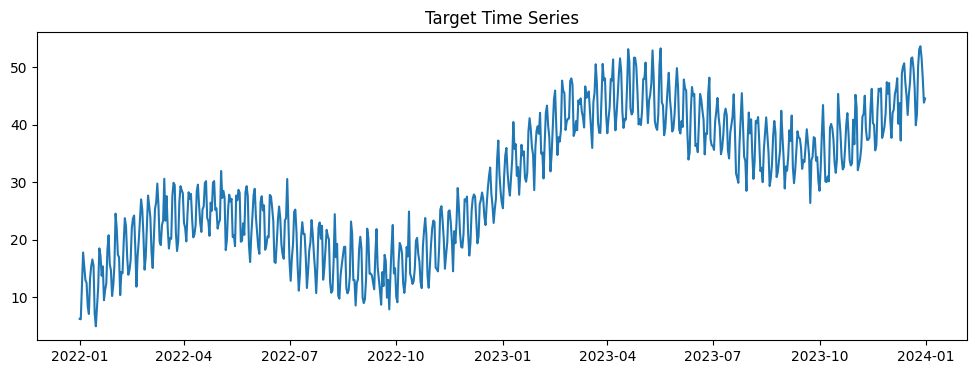

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(df["value"])
plt.title("Target Time Series")
plt.show()

# Simple Lag Features
## One-Step Lag

In [15]:
df["lag_1"] = df["value"].shift(1)


This enforces causality:

> $\bar{y_t} = f(y_{t-1})$
 
## Multiple Lags

In [23]:
LAGS = [1, 2, 3, 7, 14]

for lag in LAGS:
    df[f"lag_{lag}"] = df["value"].shift(lag)

### Lag selection guidance:

- Use ACF/PACF insights
- Include seasonal lags explicitly
- Avoid excessive lag depth

## Visualizing Lag Relationships

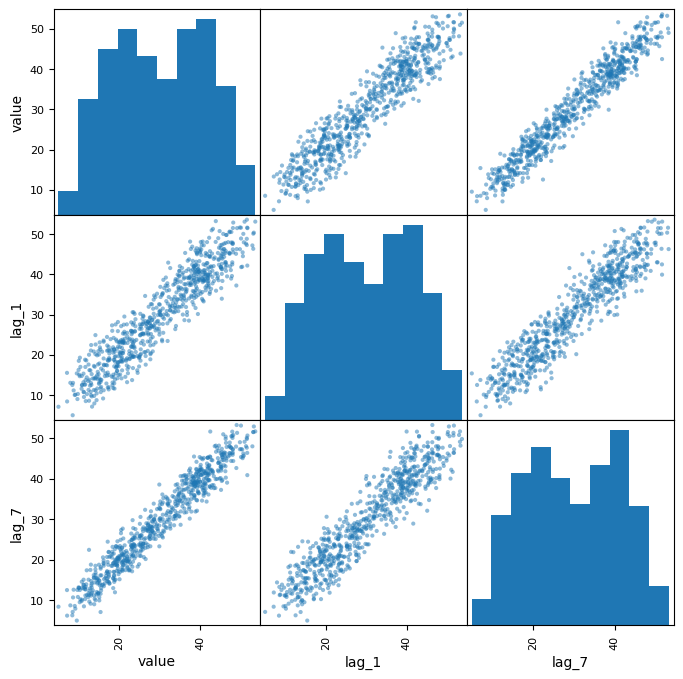

In [28]:
pd.plotting.scatter_matrix(
    df[["value", "lag_1", "lag_7"]].dropna(),
    figsize=(8, 8)
)
plt.show()


## Conditional Lag Features

Lag behavior may differ by context.

Example: weekday vs weekend

In [31]:
df["is_weekend"] = df.index.dayofweek >= 5
df["lag_1_weekend"] = df["lag_1"] * df["is_weekend"]


# Multi-Step Forecasting Setup
## Direct Strategy Example

Predict $y_{t+2}$


In [36]:
df["y_t_plus_2"] = df["value"].shift(-2)

This column is a target, never a feature.

## Leakage Check (Critical)

In [39]:
df.head(10)

,value,lag_1,lag_2,lag_3,lag_7,lag_14,is_weekend,lag_1_weekend,y_t_plus_2
date,,,,,,,,,
2022-01-01,6.290922,NaN,NaN,NaN,NaN,NaN,True,NaN,11.921313
2022-01-02,6.213400,6.290922,NaN,NaN,NaN,NaN,True,6.290922,17.807850
2022-01-03,11.921313,6.213400,6.290922,NaN,NaN,NaN,False,0.000000,15.485460
2022-01-04,17.807850,11.921313,6.213400,6.290922,NaN,NaN,False,0.000000,13.006510
2022-01-05,15.485460,17.807850,11.921313,6.213400,NaN,NaN,False,0.000000,12.520305
2022-01-06,13.006510,15.485460,17.807850,11.921313,NaN,NaN,False,0.000000,8.417105
2022-01-07,12.520305,13.006510,15.485460,17.807850,NaN,NaN,False,0.000000,7.133939
2022-01-08,8.417105,12.520305,13.006510,15.485460,6.290922,NaN,True,12.520305,13.291879
2022-01-09,7.133939,8.417105,12.520305,13.006510,6.213400,NaN,True,8.417105,15.413286


Verify:

- All lag_* columns use .shift(+k)
- Targets use .shift(-h)
- No future values appear in features
## Handling Missing Values

Lag features introduce NaNs.

### Safe Options

In [42]:
df_lagged = df.dropna()

In [44]:
df_lagged = df.iloc[max(LAGS):]

Never forward-fill lagged targets.

## Feature Matrix and Target

In [49]:
X = df_lagged.drop(columns=["value", "y_t_plus_2"])
y = df_lagged["value"]

## Sanity Check

In [52]:
X.head()
y.head()

date
2022-01-15     4.997233
2022-01-16     8.508894
2022-01-17    11.737077
2022-01-18    18.519649
2022-01-19    17.258942
Freq: D, Name: value, dtype: float64

Ensure:

- No target leakage
- Proper alignment
- Chronological order preserved

# Practical Guidelines

| Decision      | Recommendation        |
| ------------- | --------------------- |
| Lag depth     | Based on ACF + domain |
| Seasonal lags | Always explicit       |
| Too many lags | Risk overfitting      |
| ML models     | Require lag features  |
| Linear models | AR-like behavior      |


# Common Mistakes

- ❌ Using .shift(-1) as feature
- ❌ Shuffling after lag creation
- ❌ Filling NaNs with future values
- ❌ Mixing horizons unintentionally

# How This Feeds the Pipeline


| Stage               | Usage                |
| ------------------- | -------------------- |
| Feature Engineering | Core temporal signal |
| Modeling            | ML & hybrid models   |
| Validation          | Horizon-aware splits |
| Production          | Real-time inference  |


# Key Rule

> Every lag feature must represent information that would have been available at prediction time.